In [ ]:
# !pip install -U gdown ultralytics scikit-learn albumentations timm torchinfo

In [ ]:
!pip install -qq ultralytics easyocr Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 113.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 26.6 MB/s eta 0:00:00


In [ ]:
!gdown 15bTQg7W2NXg68ERJDSpY1t7EtL8eJ7az
!mkdir -p datasets
!unzip -q icdar2003.zip -d datasets

Downloading...
From (original): https://drive.google.com/uc?id=15bTQg7W2NXg68ERJDSpY1t7EtL8eJ7az
From (redirected): https://drive.google.com/uc?id=15bTQg7W2NXg68ERJDSpY1t7EtL8eJ7az&confirm=t&uuid=a23e505b-af4d-441d-b9aa-9db1c37692e3
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 53.4MB/s]


In [ ]:
import os
import random
import shutil
import time
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import ultralytics
import yaml
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from ultralytics import YOLO

import json
import easyocr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import Levenshtein

# Configure matplotlib for inline display in Jupyter notebooks
%matplotlib inline

ultralytics.checks()
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Ultralytics 8.3.238 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 38.6/112.6 GB disk)
Using device: cuda


---
# PART 1: TEXT DETECTION TRAINING (YOLO)
## 1. Extract Data from XML for Detection

In [ ]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [ ]:
dataset_dir = "datasets/SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(
    words_xml_path
)

In [ ]:
print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


## 2. Convert to YOLO Format

In [ ]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for img_path, img_size, bbs in zip(image_paths, image_sizes, bounding_boxes):
        img_w, img_h = img_size
        yolo_bbs = []

        for bb in bbs:
            x, y, w, h = bb
            x_center = (x + w / 2) / img_w
            y_center = (y + h / 2) / img_h
            w_norm = w / img_w
            h_norm = h / img_h

            yolo_bbs.append([0, x_center, y_center, w_norm, h_norm])

        yolo_data.append((img_path, yolo_bbs))

    return yolo_data


yolo_data = convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)
print(f"Number of YOLO data: {len(yolo_data)}")
print(f"Example YOLO data: {yolo_data[0]}")

Number of YOLO data: 250
Example YOLO data: ('apanar_06.08.2002/IMG_1261.JPG', [[0, 0.194375, 0.40791666666666665, 0.17125, 0.1625], [0, 0.5321875, 0.40208333333333335, 0.424375, 0.1525], [0, 0.309375, 0.5825, 0.38875, 0.145], [0, 0.67875, 0.5770833333333333, 0.27875, 0.15583333333333332], [0, 0.0746875, 0.04125, 0.059375, 0.0725], [0, 0.2159375, 0.03833333333333333, 0.123125, 0.07333333333333333], [0, 0.5309375, 0.03375, 0.071875, 0.0675], [0, 0.19625, 0.7645833333333333, 0.1425, 0.11583333333333333], [0, 0.3471875, 0.7770833333333333, 0.103125, 0.09083333333333334], [0, 0.4496875, 0.7758333333333334, 0.044375, 0.08833333333333333], [0, 0.571875, 0.7620833333333333, 0.13625, 0.1175]])


## 3. Train/Val Split for Detection

In [ ]:
train_yolo_data, val_yolo_data = train_test_split(
    yolo_data, test_size=0.2, random_state=42
)

print(f"Train YOLO data: {len(train_yolo_data)}")
print(f"Val YOLO data: {len(val_yolo_data)}")

Train YOLO data: 200
Val YOLO data: 50


## 4. Save YOLO Data

In [ ]:
def save_yolo_data(data, split, save_dir, dataset_dir):
    split_dir = os.path.join(save_dir, split)
    images_dir = os.path.join(split_dir, "images")
    labels_dir = os.path.join(split_dir, "labels")

    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for img_path, yolo_bbs in data:
        img_name = img_path.replace("/", "_")
        img_src = os.path.join(dataset_dir, img_path)
        img_dest = os.path.join(images_dir, img_name)

        shutil.copy(img_src, img_dest)

        label_name = img_name.replace(".JPG", ".txt")
        label_path = os.path.join(labels_dir, label_name)

        with open(label_path, "w") as f:
            for bb in yolo_bbs:
                f.write(f"{bb[0]} {bb[1]} {bb[2]} {bb[3]} {bb[4]}\n")

In [ ]:
save_yolo_data_dir = "yolo_data"
save_yolo_data(train_yolo_data, "train", save_yolo_data_dir, dataset_dir)
save_yolo_data(val_yolo_data, "val", save_yolo_data_dir, dataset_dir)

## 5. Create YOLO Config YAML

In [ ]:
class_labels = ["text"]
data_yaml = {
    "path": os.path.abspath(save_yolo_data_dir),
    "train": "train/images",
    "val": "val/images",
    "nc": 1,
    "names": class_labels,
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, "data.yml")
with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"YOLO config saved to: {yolo_yaml_path}")

YOLO config saved to: yolo_data/data.yml


## 6. Train YOLO Model

YOLO Training Data Visualization
Total train images: 200
Total val images: 50


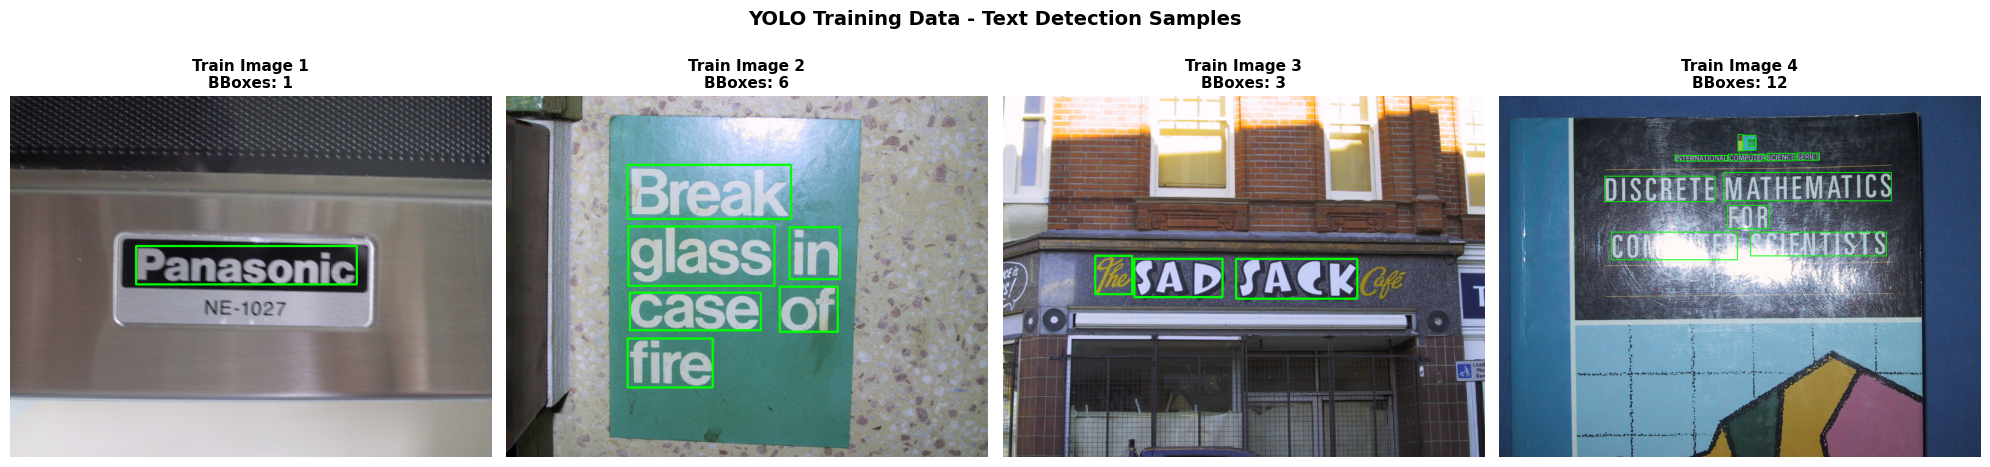

In [ ]:
# Visualize YOLO training data
print("YOLO Training Data Visualization")
print("=" * 80)
print(f"Total train images: {len(train_yolo_data)}")
print(f"Total val images: {len(val_yolo_data)}")

# Display sample train images with bounding boxes
sample_train = random.sample(train_yolo_data, min(4, len(train_yolo_data)))

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for idx, (img_path, yolo_bbs) in enumerate(sample_train):
    full_path = os.path.join(dataset_dir, img_path)
    img = cv2.imread(full_path)
    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Draw bounding boxes
    for bb in yolo_bbs:
        cls, x_center, y_center, bbox_w, bbox_h = bb
        x1 = int((x_center - bbox_w / 2) * w)
        y1 = int((y_center - bbox_h / 2) * h)
        x2 = int((x_center + bbox_w / 2) * w)
        y2 = int((y_center + bbox_h / 2) * h)

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    axes[idx].imshow(img)
    axes[idx].set_title(f"Train Image {idx+1}\nBBoxes: {len(yolo_bbs)}", fontsize=11, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('YOLO Training Data - Text Detection Samples', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Load YOLO model
yolo_model = YOLO("yolo11m.pt")

# Train model
yolo_results = yolo_model.train(
    data=yolo_yaml_path,
    epochs=80,
    imgsz=640,
    cache=True,
    patience=20,
    plots=True,
)

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_data/data.yml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretra

## 7. Evaluate YOLO Model

In [ ]:
yolo_model_path = "runs/detect/train/weights/best.pt"
yolo_model = YOLO(yolo_model_path)
yolo_metrics = yolo_model.val()

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2987.2±741.5 MB/s, size: 267.8 KB)
val: Scanning /content/yolo_data/val/labels.cache... 48 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 50/50 95.7Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 2.8it/s 1.4s
                   all         50        215      0.843      0.767      0.804      0.629
Speed: 3.5ms preprocess, 15.2ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /content/runs/detect/val


---
# PART 2: TEXT RECOGNITION TRAINING (CRNN)
## 8. Extract and Crop Text Regions for Recognition

In [ ]:
def extract_data_from_xml_for_recognition(root_dir):
    xml_path = os.path.join(root_dir, "words.xml")
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img_paths = []
    img_sizes = []
    img_labels = []
    bboxes = []

    for img in root:
        bbs_of_img = []
        labels_of_img = []

        for bbs in img.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_img.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_img.append(bb[0].text.lower())

        img_path = os.path.join(root_dir, img[0].text)
        img_paths.append(img_path)
        img_sizes.append((int(img[1].attrib["x"]), int(img[1].attrib["y"])))
        bboxes.append(bbs_of_img)
        img_labels.append(labels_of_img)

    return img_paths, img_sizes, img_labels, bboxes

In [ ]:
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml_for_recognition(
    dataset_dir
)
print(f"Total images: {len(img_paths)}")
print(f"Total bounding boxes: {sum([len(bbs) for bbs in bboxes])}")

Total images: 250
Total bounding boxes: 1097


## 9. Crop and Save Text Regions

In [ ]:
def crop_text(img_paths, img_labels, bboxes, save_dir="cropped_text"):
    os.makedirs(save_dir, exist_ok=True)

    cropped_paths = []
    labels = []

    for img_path, img_label, bbox in zip(img_paths, img_labels, bboxes):
        img = cv2.imread(img_path)

        # Skip if image could not be loaded
        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue

        for i, (bb, label) in enumerate(zip(bbox, img_label)):
            x, y, w, h = bb
            x, y, w, h = int(x), int(y), int(w), int(h)

            # Ensure bounding box is within image bounds
            x = max(0, x)
            y = max(0, y)
            w = max(1, w)
            h = max(1, h)
            x_end = min(img.shape[1], x + w)
            y_end = min(img.shape[0], y + h)

            # Skip if bounding box is invalid
            if x_end <= x or y_end <= y:
                print(f"Warning: Invalid bounding box for {img_path}")
                continue

            cropped_img = img[y:y_end, x:x_end]

            # Skip if crop is empty
            if cropped_img.size == 0:
                print(f"Warning: Empty crop for {img_path} at bbox {bb}")
                continue

            img_name = os.path.basename(img_path).replace(".JPG", "")
            save_path = os.path.join(save_dir, f"{img_name}_{i}.jpg")

            cv2.imwrite(save_path, cropped_img)

            cropped_paths.append(save_path)
            labels.append(label)

    return cropped_paths, labels

In [ ]:
cropped_img_paths, labels = crop_text(img_paths, img_labels, bboxes)
print(f"Total cropped images: {len(cropped_img_paths)}")
print(f"Example label: {labels[:5]}")

Total cropped images: 1097
Example label: ['self', 'adhesive', 'address', 'labels', '36']


## 10. Prepare Characters and Encoding

In [ ]:
# Define vocabulary
chars = "0123456789abcdefghijklmnopqrstuvwxyz-"
vocab_size = len(chars)
blank_char = "-"

char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

print(f"Vocabulary size: {vocab_size}")
print(f"char_to_idx: {char_to_idx}")

Vocabulary size: 37
char_to_idx: {'-': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}


In [ ]:
# Calculate max label length
max_label_len = max([len(label) for label in labels])
print(f"Max label length: {max_label_len}")

Max label length: 14


In [ ]:
def encode(text, char_to_idx, max_label_len):
    encoded = []
    for char in text:
        encoded.append(char_to_idx[char])

    label_len = len(encoded)

    # Pad with 0s
    encoded += [0] * (max_label_len - len(encoded))

    return torch.LongTensor(encoded), torch.tensor(label_len, dtype=torch.long)


def decode(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None

        for token in seq:
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

## 12. Train/Val/Test Split for Recognition

In [ ]:
seed = 0
val_size = 0.1
test_size = 0.1
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    cropped_img_paths,
    labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 888, Val: 110, Test: 99


## 13. Create PyTorch Dataset

In [ ]:
class STRDataset(Dataset):
    def __init__(
        self,
        X,
        y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None,
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label, self.char_to_idx, self.max_label_len
            )
        return img, encoded_label, label_len

## 15. Enhanced Data Transforms and DataLoaders

In [ ]:
## Data Transforms
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420), interpolation=2),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.Grayscale(num_output_channels=1),
            transforms.GaussianBlur(kernel_size=3),
            transforms.RandomAffine(degrees=1, shear=1),
            transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420), interpolation=2),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

train_dataset = STRDataset(
    X_train,
    y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["train"],
)

val_dataset = STRDataset(
    X_val,
    y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)

test_dataset = STRDataset(
    X_test,
    y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms["val"],
)

train_batch_size = 256
test_batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

## 16. Define CRNN Model

In [ ]:
class CRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = ***Your Code Here***
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        # ResNet34 outputs 512 channels
        self.mapSeq = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            ***Your Code Here***
        )

    def forward(self, x):
        x = ***Your Code Here***
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = ***Your Code Here***
        x, _ = ***Your Code Here***
        x = self.layer_norm(x)
        x = ***Your Code Here***
        x = x.permute(1, 0, 2)  # Based on CTC

        return x

In [ ]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

crnn_model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

## 17. Training Functions

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels, labels_len) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            logits_lens = torch.full(
                size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss


def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
    max_grad_norm=2,
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        start = time.time()

        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long,
            ).to(device)

            loss = criterion(outputs, labels.cpu(), logits_lens.cpu(), labels_len.cpu())

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(
            f"EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\t Time: {time.time() - start:.2f} seconds"
        )

        scheduler.step()

    return train_losses, val_losses

In [ ]:
def decode_label(encoded_sequences, idx_to_char, blank_char="-"):
    decoded_sequences = []

    for seq in encoded_sequences:
        decoded_label = []
        for idx, token in enumerate(seq):
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    decoded_label.append(char)

        decoded_sequences.append("".join(decoded_label))

    return decoded_sequences

Training Data Batch Visualization
Batch size: 256
Image shape: torch.Size([256, 1, 100, 420])
Labels shape: torch.Size([256, 14])
Label lengths: tensor([ 2, 10,  5,  4,  7,  4,  2,  4])

Sample labels: ['by', 'greenstead', 'order', 'moto', 'hygiene', 'when', 'in', 'fire']


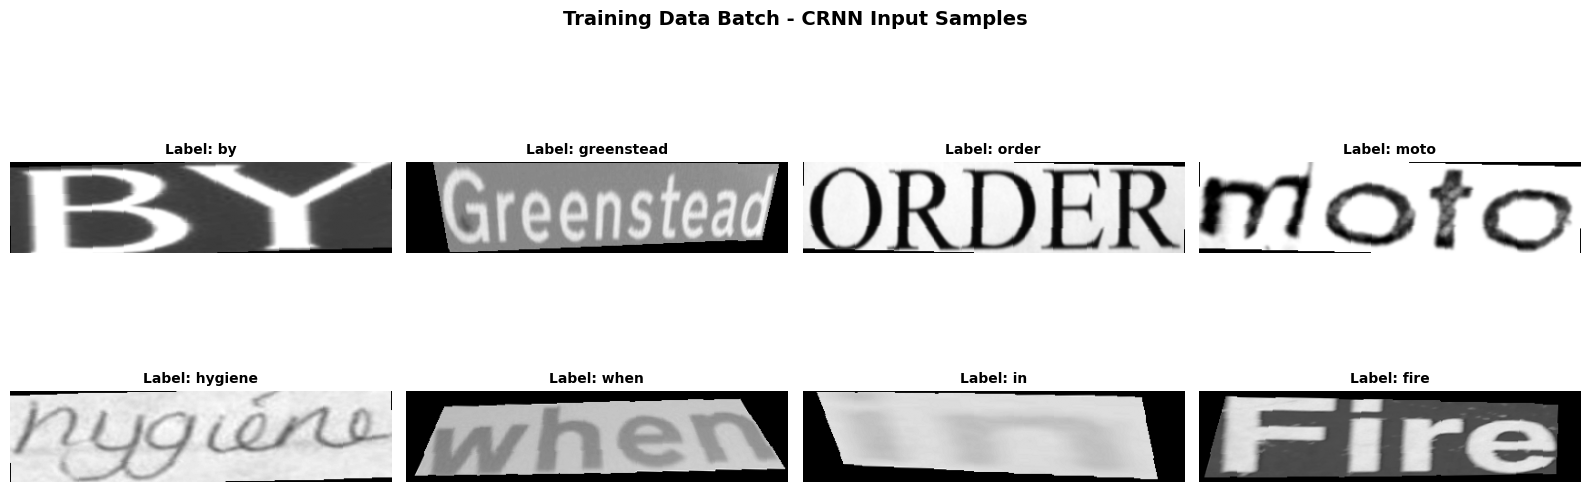

In [ ]:
# Visualize training data batch
train_features, train_labels, train_lengths = next(iter(train_loader))

print("Training Data Batch Visualization")
print("=" * 80)
print(f"Batch size: {train_features.shape[0]}")
print(f"Image shape: {train_features.shape}")
print(f"Labels shape: {train_labels.shape}")
print(f"Label lengths: {train_lengths[:8]}")

# Decode labels to show actual text
decoded_labels = decode_label(train_labels, idx_to_char)
print(f"\nSample labels: {decoded_labels[:8]}")

# Display first 8 images with their labels
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes = axes.flatten()

for i in range(min(8, len(train_features))):
    img = train_features[i].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # Convert from CHW to HWC

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {decoded_labels[i]}", fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Training Data Batch - CRNN Input Samples', fontsize=14, fontweight='bold', y=1.02)
plt.show()

## 18. Train CRNN Model

In [ ]:
epochs = 80
lr = 1e-3
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction="mean",
)
optimizer = torch.optim.Adam(
    crnn_model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=0.1
)

train_losses, val_losses = fit(
    crnn_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs,
)

EPOCH 1:	Train loss: 6.1107	Val loss: 4.1506		 Time: 7.24 seconds
EPOCH 2:	Train loss: 3.9608	Val loss: 3.7580		 Time: 7.00 seconds
EPOCH 3:	Train loss: 3.6832	Val loss: 3.4709		 Time: 6.74 seconds
EPOCH 4:	Train loss: 3.5902	Val loss: 3.4594		 Time: 6.93 seconds
EPOCH 5:	Train loss: 3.4460	Val loss: 3.3649		 Time: 6.74 seconds
EPOCH 6:	Train loss: 3.4004	Val loss: 3.3157		 Time: 6.83 seconds
EPOCH 7:	Train loss: 3.3583	Val loss: 3.3051		 Time: 6.89 seconds
EPOCH 8:	Train loss: 3.3552	Val loss: 3.3246		 Time: 6.78 seconds
EPOCH 9:	Train loss: 3.3471	Val loss: 3.2399		 Time: 6.86 seconds
EPOCH 10:	Train loss: 3.2778	Val loss: 3.1776		 Time: 6.79 seconds
EPOCH 11:	Train loss: 3.2261	Val loss: 3.1296		 Time: 7.05 seconds
EPOCH 12:	Train loss: 3.1345	Val loss: 3.0821		 Time: 6.80 seconds
EPOCH 13:	Train loss: 3.0626	Val loss: 3.0032		 Time: 6.85 seconds
EPOCH 14:	Train loss: 2.9373	Val loss: 2.8439		 Time: 6.97 seconds
EPOCH 15:	Train loss: 2.8214	Val loss: 2.7173		 Time: 6.82 seconds
EPOC

## 19. Plot Training History

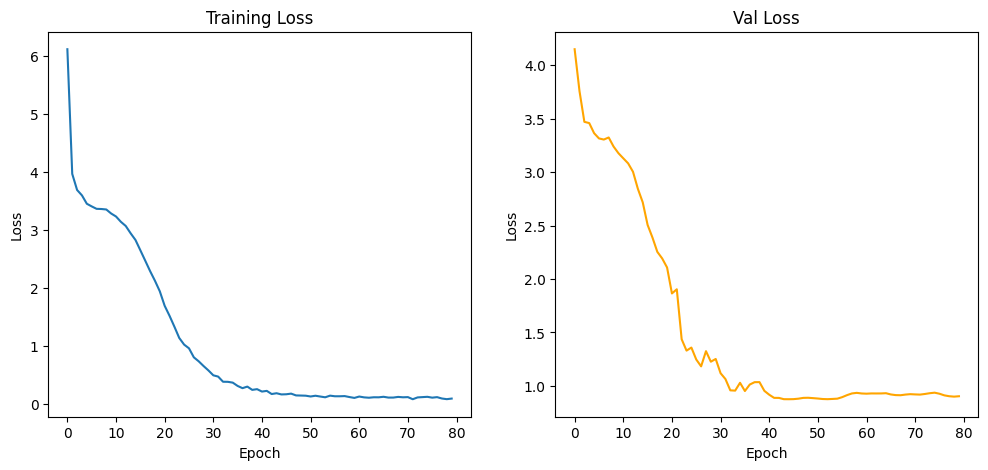

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].plot(val_losses, color="orange")
ax[1].set_title("Val Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
plt.show()

## 20. Visualize Predictions

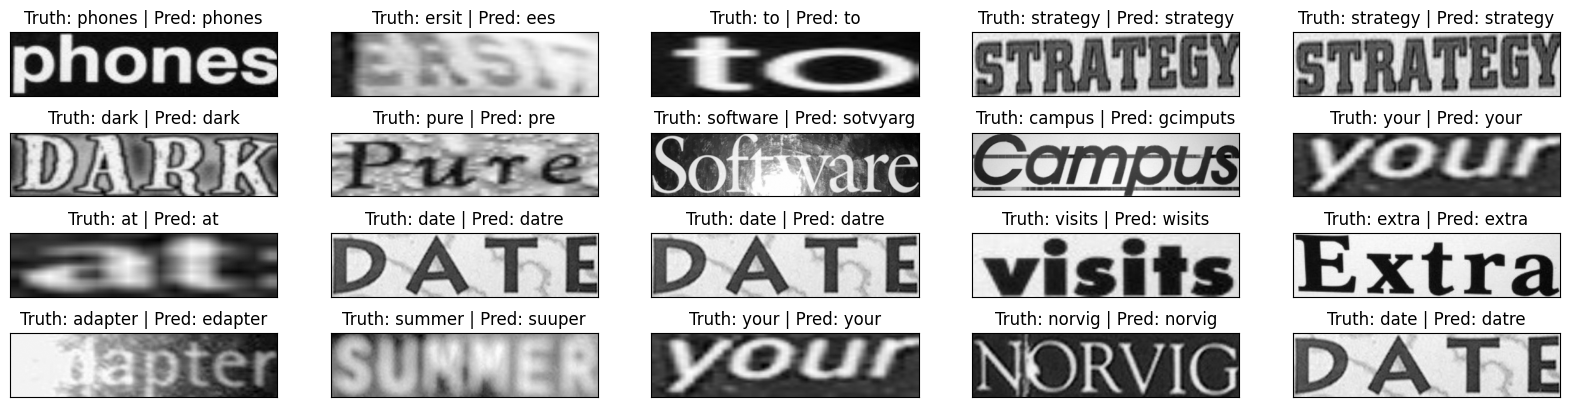

In [ ]:
# View samples from test set
sample_result = []

for i in range(20):
    idx = np.random.randint(len(test_dataset))
    img, label, label_len = test_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode_label([label], idx_to_char)[0]
    logits = crnn_model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(20, 5))
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f"Truth: {label} | Pred: {pred_text}"

    ax.imshow(img.permute(1, 2, 0), cmap="gray")
    ax.set_title(title)

plt.show()

In [ ]:
# Save CRNN model
crnn_model_path = "ocr_crnn.pt"
torch.save(crnn_model.state_dict(), crnn_model_path)
print(f"CRNN model saved to: {crnn_model_path}")

# YOLO model is already saved in runs/detect/train/weights/best.pt
print(f"YOLO model saved to: runs/detect/train/weights/best.pt")

CRNN model saved to: ocr_crnn.pt
YOLO model saved to: runs/detect/train/weights/best.pt


## 21. Save Models

---
# PART 3: MODEL COMPARISON

So sánh 3 models trên test dataset:
- **YOLO + CRNN (Ours)**
- **YOLO + TrOCR**
- **EasyOCR (End-to-End)**

Đánh giá theo:
- Character Accuracy
- Word Accuracy  
- Inference Speed

Với 2 confidence thresholds: **0.3**

## 22. Load Models for Comparison

In [ ]:
# Load YOLO + CRNN (our trained models)
yolo_model_path = "runs/detect/train/weights/best.pt"
crnn_model_path = "ocr_crnn.pt"

yolo_det = YOLO(yolo_model_path)
print("YOLO model loaded")

# Load CRNN model
crnn_inference = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)
crnn_inference.load_state_dict(torch.load(crnn_model_path, map_location=device))
crnn_inference.eval()
print("CRNN model loaded")

YOLO model loaded
CRNN model loaded


In [ ]:
# Load TrOCR
print("Loading TrOCR model...")
trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed").to(device)
trocr_model.eval()
print("TrOCR model loaded\n")

# ============================================================================
# HIỂN THỊ CẤU TRÚC CHI TIẾT CỦA TrOCR MODEL
# ============================================================================
print("="*100)
print("TROCR MODEL ARCHITECTURE - ENCODER & DECODER COMPONENTS")
print("="*100)

# 1. Model Config Info
print("\n[1] MODEL CONFIGURATION:")
print("-" * 100)
print(f"  • Model Type: {type(trocr_model).__name__}")
print(f"  • Device: {device}")
print(f"  • Total Parameters: {sum(p.numel() for p in trocr_model.parameters()):,}")
print(f"  • Trainable Parameters: {sum(p.numel() for p in trocr_model.parameters() if p.requires_grad):,}")

# 2. Encoder Structure
print("\n[2] ENCODER (Vision Component - DeiT/ViT):")
print("-" * 100)
encoder = trocr_model.encoder
print(f"  • Type: {type(encoder).__name__}")
print(f"  • Config: {encoder.config}")
print("\n  • Encoder Layers:")
for name, module in encoder.named_children():
    if not name.startswith('_'):
        param_count = sum(p.numel() for p in module.parameters())
        print(f"      - {name}: {type(module).__name__} ({param_count:,} params)")

# 3. Decoder Structure
print("\n[3] DECODER (Text Generation Component - GPT-2 based):")
print("-" * 100)
decoder = trocr_model.decoder
print(f"  • Type: {type(decoder).__name__}")
print(f"  • Config: {decoder.config}")
print("\n  • Decoder Layers:")
for name, module in decoder.named_children():
    if not name.startswith('_'):
        param_count = sum(p.numel() for p in module.parameters())
        print(f"      - {name}: {type(module).__name__} ({param_count:,} params)")

# 4. Model Config Details
print("\n[4] DETAILED MODEL CONFIGURATION:")
print("-" * 100)
config = trocr_model.config
decoder_config = config.decoder
print(f"  • is_encoder_decoder: {config.is_encoder_decoder}")
print(f"  • Vocab Size: {decoder_config.vocab_size}")
print(f"  • Max Position Embeddings: {getattr(decoder_config, 'max_position_embeddings', 'N/A')}")
print(f"  • Hidden Size: {decoder_config.hidden_size}")
print(f"  • Num Hidden Layers: {decoder_config.num_hidden_layers}")
print(f"  • Num Attention Heads: {decoder_config.num_attention_heads}")
print(f"  • Intermediate Size: {getattr(decoder_config, 'intermediate_size', 'N/A')}")
print(f"  • Dropout: {getattr(decoder_config, 'dropout', getattr(decoder_config, 'hidden_dropout_prob', 'N/A'))}")
print(f"  • Attention Dropout: {getattr(decoder_config, 'attention_dropout', getattr(decoder_config, 'attention_probs_dropout_prob', 'N/A'))}")

# 5. Full Model Summary
print("\n[5] FULL MODEL STRUCTURE:")
print("-" * 100)
print(trocr_model)

print("\n" + "="*100)
print("TrOCR Model loaded and ready for inference!")
print("="*100 + "\n")

Loading TrOCR model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

TrOCR model loaded

TROCR MODEL ARCHITECTURE - ENCODER & DECODER COMPONENTS

[1] MODEL CONFIGURATION:
----------------------------------------------------------------------------------------------------
  • Model Type: VisionEncoderDecoderModel
  • Device: cuda
  • Total Parameters: 333,921,792
  • Trainable Parameters: 333,921,792

[2] ENCODER (Vision Component - DeiT/ViT):
----------------------------------------------------------------------------------------------------
  • Type: ViTModel
  • Config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "dtype": "float32",
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "transformers_v

In [ ]:
# Load EasyOCR
print("Loading EasyOCR model...")
easyocr_reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
print("EasyOCR model loaded")

Loading EasyOCR model...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteEasyOCR model loaded


## 23. Define Evaluation Metrics

In [ ]:
def calculate_char_accuracy(pred, gt):
    """Calculate character-level accuracy using Levenshtein distance"""
    if len(gt) == 0:
        return 1.0 if len(pred) == 0 else 0.0

    distance = Levenshtein.distance(pred.lower(), gt.lower())
    accuracy = 1 - (distance / max(len(pred), len(gt)))
    return max(0, accuracy)

def calculate_word_accuracy(pred, gt):
    """Calculate exact word match accuracy"""
    return 1.0 if pred.lower().strip() == gt.lower().strip() else 0.0

def calculate_metrics(predictions, ground_truths):
    """Calculate average metrics for a list of predictions"""
    char_accs = []
    word_accs = []

    for pred, gt in zip(predictions, ground_truths):
        char_accs.append(calculate_char_accuracy(pred, gt))
        word_accs.append(calculate_word_accuracy(pred, gt))

    return {
        'char_accuracy': np.mean(char_accs) * 100,
        'word_accuracy': np.mean(word_accs) * 100,
        'total_samples': len(predictions)
    }

## 24. Prepare Test Dataset from Full Images

In [ ]:
# Create test set from validation split (for evaluation)
# We'll use a subset of val_yolo_data for testing
test_samples = val_yolo_data[:50]  # Use first 50 images from validation

# Extract ground truth for each text region in test images
test_data = []
for img_rel_path, yolo_bbs in test_samples:
    img_path = os.path.join(dataset_dir, img_rel_path)

    # Find corresponding labels
    for idx, (img_p, labels_list, bbs_list) in enumerate(zip(image_paths, image_labels, bounding_boxes)):
        if img_p == img_rel_path:
            # Load image
            img = cv2.imread(img_path)
            if img is None:
                continue

            # For each bounding box, store image, bbox, and label
            for bb, label in zip(bbs_list, labels_list):
                x, y, w, h = [int(v) for v in bb]
                test_data.append({
                    'image_path': img_path,
                    'bbox': (x, y, w, h),
                    'label': label,
                    'image': img
                })
            break

print(f"Test dataset prepared: {len(test_data)} text regions from {len(test_samples)} images")

Test dataset prepared: 227 text regions from 50 images


## 25. YOLO + CRNN, YOLO + TrOCR and EasyOCR

In [ ]:
# Transform for CRNN inference
crnn_transform = transforms.Compose([
    transforms.Resize((100, 420)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

def inference_yolo_crnn(img_path, conf_threshold=0.3):
    """Inference using YOLO + CRNN pipeline"""
    predictions = []

    # YOLO Detection
    results = yolo_det(img_path, verbose=False, conf=conf_threshold)
    detections = json.loads(results[0].to_json())

    img = cv2.imread(img_path)

    for det in detections:
        if det['confidence'] < conf_threshold:
            continue

        # Get bounding box
        box = det['box']
        x1, y1, x2, y2 = int(box['x1']), int(box['y1']), int(box['x2']), int(box['y2'])

        # Crop text region
        cropped = img[y1:y2, x1:x2]
        if cropped.size == 0:
            continue

        # Convert to PIL Image
        cropped_pil = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

        # CRNN Recognition
        img_tensor = crnn_transform(cropped_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = crnn_inference(img_tensor)
            pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

        predictions.append({
            'bbox': (x1, y1, x2-x1, y2-y1),
            'text': pred_text,
            'confidence': det['confidence']
        })

    return predictions

In [ ]:
def inference_yolo_trocr(img_path, conf_threshold=0.3):
    """Inference using YOLO + TrOCR pipeline"""
    predictions = []

    # YOLO Detection
    results = yolo_det(img_path, verbose=False, conf=conf_threshold)
    detections = json.loads(results[0].to_json())

    img = cv2.imread(img_path)

    for det in detections:
        if det['confidence'] < conf_threshold:
            continue

        # Get bounding box
        box = det['box']
        x1, y1, x2, y2 = int(box['x1']), int(box['y1']), int(box['x2']), int(box['y2'])

        # Crop text region
        cropped = img[y1:y2, x1:x2]
        if cropped.size == 0:
            continue

        # Convert to PIL Image (RGB)
        cropped_pil = Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

        # TrOCR Recognition
        pixel_values = trocr_processor(cropped_pil, return_tensors="pt").pixel_values.to(device)
        with torch.no_grad():
            generated_ids = trocr_model.generate(pixel_values)
            pred_text = trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        predictions.append({
            'bbox': (x1, y1, x2-x1, y2-y1),
            'text': pred_text,
            'confidence': det['confidence']
        })

    return predictions

In [ ]:
def inference_easyocr(img_path, conf_threshold=0.3):
    """Inference using EasyOCR (end-to-end)"""
    predictions = []

    # EasyOCR Detection + Recognition
    results = easyocr_reader.readtext(img_path)

    for result in results:
        bbox, text, confidence = result

        if confidence < conf_threshold:
            continue

        # Convert bbox format
        x_coords = [p[0] for p in bbox]
        y_coords = [p[1] for p in bbox]
        x1, y1 = int(min(x_coords)), int(min(y_coords))
        x2, y2 = int(max(x_coords)), int(max(y_coords))

        predictions.append({
            'bbox': (x1, y1, x2-x1, y2-y1),
            'text': text,
            'confidence': confidence
        })

    return predictions

In [ ]:
def match_predictions_to_ground_truth(predictions, ground_truths, iou_threshold=0.3):
    """Match predicted boxes to ground truth boxes using IoU"""
    matched_preds = []
    matched_gts = []

    for gt in ground_truths:
        gt_bbox = gt['bbox']
        best_iou = 0
        best_pred = None

        for pred in predictions:
            pred_bbox = pred['bbox']

            # Calculate IoU
            x1_gt, y1_gt, w_gt, h_gt = gt_bbox
            x1_pred, y1_pred, w_pred, h_pred = pred_bbox

            x1_inter = max(x1_gt, x1_pred)
            y1_inter = max(y1_gt, y1_pred)
            x2_inter = min(x1_gt + w_gt, x1_pred + w_pred)
            y2_inter = min(y1_gt + h_gt, y1_pred + h_pred)

            if x2_inter > x1_inter and y2_inter > y1_inter:
                inter_area = (x2_inter - x1_inter) * (y2_inter - y1_inter)
                area_gt = w_gt * h_gt
                area_pred = w_pred * h_pred
                union_area = area_gt + area_pred - inter_area
                iou = inter_area / union_area if union_area > 0 else 0

                if iou > best_iou:
                    best_iou = iou
                    best_pred = pred

        if best_iou >= iou_threshold and best_pred:
            matched_preds.append(best_pred['text'])
            matched_gts.append(gt['label'])

    return matched_preds, matched_gts

In [ ]:
def evaluate_model(inference_func, test_samples, model_name, conf_threshold=0.3):
    """Evaluate a model on test samples"""
    print(f"\n{'='*60}")
    print(f"Evaluating {model_name}...")
    print(f"{'='*60}")

    all_predictions = []
    all_ground_truths = []
    total_time = 0
    processed_images = 0

    # Group test data by image
    images_dict = {}
    for item in test_samples:
        img_path = item['image_path']
        if img_path not in images_dict:
            images_dict[img_path] = []
        images_dict[img_path].append(item)

    for img_path, gt_items in images_dict.items():
        try:
            # Run inference
            start_time = time.time()
            predictions = inference_func(img_path, conf_threshold=conf_threshold)
            elapsed_time = time.time() - start_time
            total_time += elapsed_time
            processed_images += 1

            # Match predictions to ground truth
            matched_preds, matched_gts = match_predictions_to_ground_truth(
                predictions, gt_items, iou_threshold=0.3
            )

            all_predictions.extend(matched_preds)
            all_ground_truths.extend(matched_gts)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    # Calculate metrics
    if len(all_predictions) > 0:
        metrics = calculate_metrics(all_predictions, all_ground_truths)
        avg_time = total_time / processed_images if processed_images > 0 else 0

        print(f"\nResults for {model_name}:")
        print(f"  - Character Accuracy: {metrics['char_accuracy']:.2f}%")
        print(f"  - Word Accuracy: {metrics['word_accuracy']:.2f}%")
        print(f"  - Average Time per Image: {avg_time:.4f}s")
        print(f"  - Total Images Processed: {processed_images}")
        print(f"  - Total Text Regions Matched: {len(all_predictions)}")

        return {
            'model': model_name,
            'char_acc': metrics['char_accuracy'],
            'word_acc': metrics['word_accuracy'],
            'avg_time': avg_time,
            'total_images': processed_images,
            'matched_regions': len(all_predictions)
        }
    else:
        print(f"No predictions matched for {model_name}!")
        return None

## 26. Run Evaluation Functions

In [ ]:
# Test with confidence threshold 0.3
conf_threshold = 0.3
print(f"\n\n{'#'*80}")
print(f"# EVALUATION WITH CONFIDENCE THRESHOLD = {conf_threshold}")
print(f"{'#'*80}\n")

# Evaluate YOLO + CRNN
results_yolo_crnn = evaluate_model(
    inference_yolo_crnn,
    test_data,
    "YOLO + CRNN (Ours)",
    conf_threshold=conf_threshold
)

# Evaluate YOLO + TrOCR
results_yolo_trocr = evaluate_model(
    inference_yolo_trocr,
    test_data,
    "YOLO + TrOCR",
    conf_threshold=conf_threshold
)

# Evaluate EasyOCR (end-to-end)
results_easyocr = evaluate_model(
    inference_easyocr,
    test_data,
    "EasyOCR (End-to-End)",
    conf_threshold=conf_threshold
)

# Store results for comparison
results_03 = [results_yolo_crnn, results_yolo_trocr, results_easyocr]



################################################################################
# EVALUATION WITH CONFIDENCE THRESHOLD = 0.3
################################################################################


Evaluating YOLO + CRNN (Ours)...

Results for YOLO + CRNN (Ours):
  - Character Accuracy: 91.37%
  - Word Accuracy: 80.42%
  - Average Time per Image: 0.0745s
  - Total Images Processed: 49
  - Total Text Regions Matched: 189

Evaluating YOLO + TrOCR...

Results for YOLO + TrOCR:
  - Character Accuracy: 91.70%
  - Word Accuracy: 77.78%
  - Average Time per Image: 0.6360s
  - Total Images Processed: 49
  - Total Text Regions Matched: 189

Evaluating EasyOCR (End-to-End)...

Results for EasyOCR (End-to-End):
  - Character Accuracy: 81.22%
  - Word Accuracy: 54.46%
  - Average Time per Image: 0.1137s
  - Total Images Processed: 49
  - Total Text Regions Matched: 112


In [ ]:
import pandas as pd

# Display comparison results for confidence threshold 0.3
print("\n" + "="*100)
print("COMPARISON RESULTS - CONFIDENCE THRESHOLD = 0.3")
print("="*100)

results = [r for r in results_03 if r]
if len(results) > 0:
    df_03 = pd.DataFrame(results)
    df_03 = df_03[['model', 'char_acc', 'word_acc', 'avg_time', 'matched_regions']]
    df_03.columns = ['Model', 'Char Acc (%)', 'Word Acc (%)', 'Speed (s/img)', 'Matched Regions']
    print(df_03.to_string(index=False))
    best_char_03 = df_03.loc[df_03['Char Acc (%)'].idxmax(), 'Model']
    best_word_03 = df_03.loc[df_03['Word Acc (%)'].idxmax(), 'Model']

    print("\n" + "="*100)
    print("SUMMARY")
    print("="*100)
    print(f"Confidence 0.3 - Best Char Acc: {best_char_03} | Best Word Acc: {best_word_03}")


COMPARISON RESULTS - CONFIDENCE THRESHOLD = 0.3
               Model  Char Acc (%)  Word Acc (%)  Speed (s/img)  Matched Regions
  YOLO + CRNN (Ours)     91.371367     80.423280       0.074453              189
        YOLO + TrOCR     91.703611     77.777778       0.635990              189
EasyOCR (End-to-End)     81.221196     54.464286       0.113694              112

SUMMARY
Confidence 0.3 - Best Char Acc: YOLO + TrOCR | Best Word Acc: YOLO + CRNN (Ours)


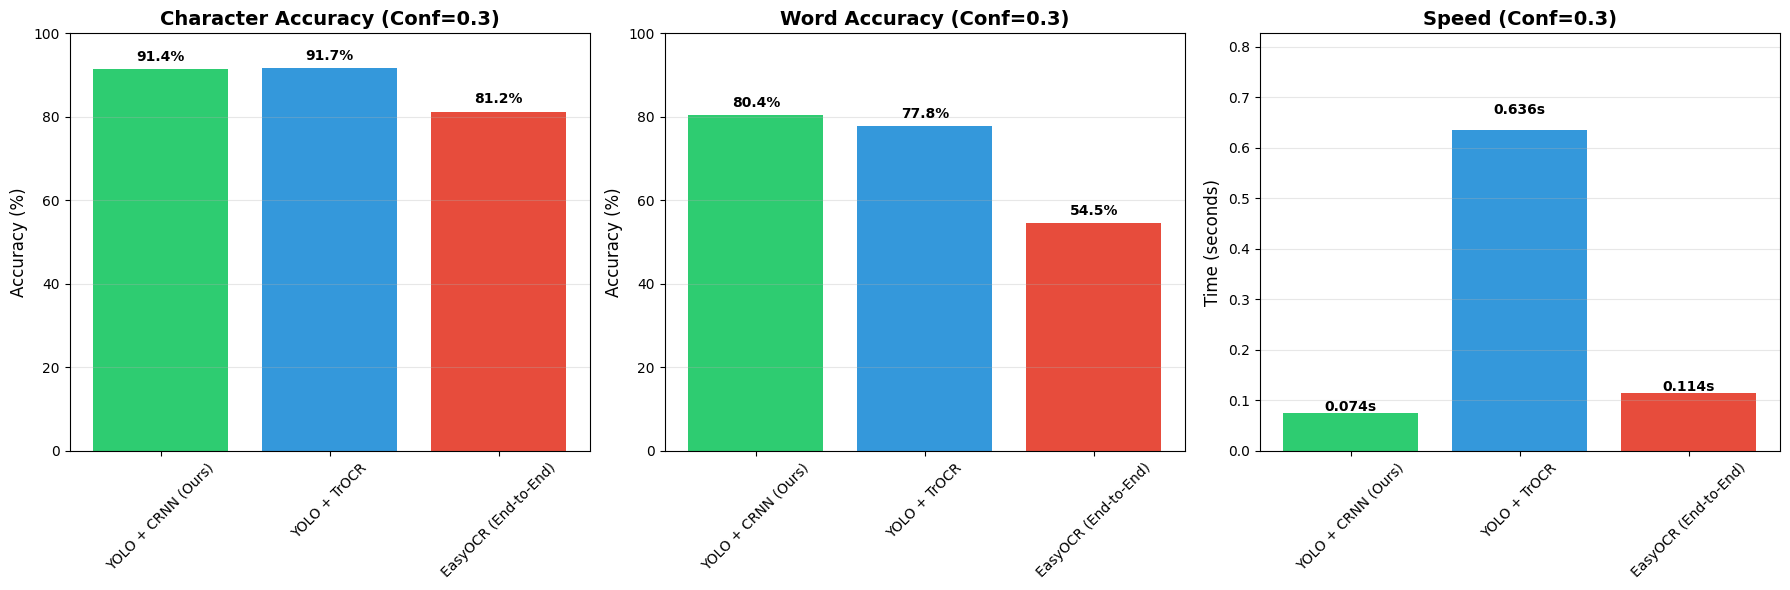

In [ ]:
if len(results_03) > 0:
    # Visualize results for confidence threshold 0.3
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    colors = ['#2ecc71', '#3498db', '#e74c3c']
    df = df_03

    # Character Accuracy
    axes[0].bar(df['Model'], df['Char Acc (%)'], color=colors)
    axes[0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0].set_title('Character Accuracy (Conf=0.3)', fontsize=14, fontweight='bold')
    axes[0].set_ylim([0, 100])
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(df['Char Acc (%)']):
        axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=10)

    # Word Accuracy
    axes[1].bar(df['Model'], df['Word Acc (%)'], color=colors)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Word Accuracy (Conf=0.3)', fontsize=14, fontweight='bold')
    axes[1].set_ylim([0, 100])
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(df['Word Acc (%)']):
        axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold', fontsize=10)

    # Speed
    axes[2].bar(df['Model'], df['Speed (s/img)'], color=colors)
    axes[2].set_ylabel('Time (seconds)', fontsize=12)
    axes[2].set_title('Speed (Conf=0.3)', fontsize=14, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)
    axes[2].tick_params(axis='x', rotation=45)

    max_speed = float(df['Speed (s/img)'].max())
    axes[2].set_ylim(0, max_speed * 1.3)

    for i, v in enumerate(df['Speed (s/img)']):
        axes[2].text(i, v + v * 0.05, f'{v:.3f}s', ha='center', fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("No results to visualize!")


SAMPLE PREDICTIONS VISUALIZATION (2 Sample Images)

────────────────────────────────────────────────────────────────────────────────────────────────────
SAMPLE IMAGE 205: datasets/SceneTrialTrain/lfsosa_12.08.2002/IMG_2535.JPG
────────────────────────────────────────────────────────────────────────────────────────────────────
Ground Truth Labels: ['133', 'a', 'centre', 'chelmsford', 'clacton', 'gt', 'harwich', 'ipswich', 'leisure', 'london', 'rollerworld', 'town', 'world', 'yarmouth']
Total regions in this image: 14



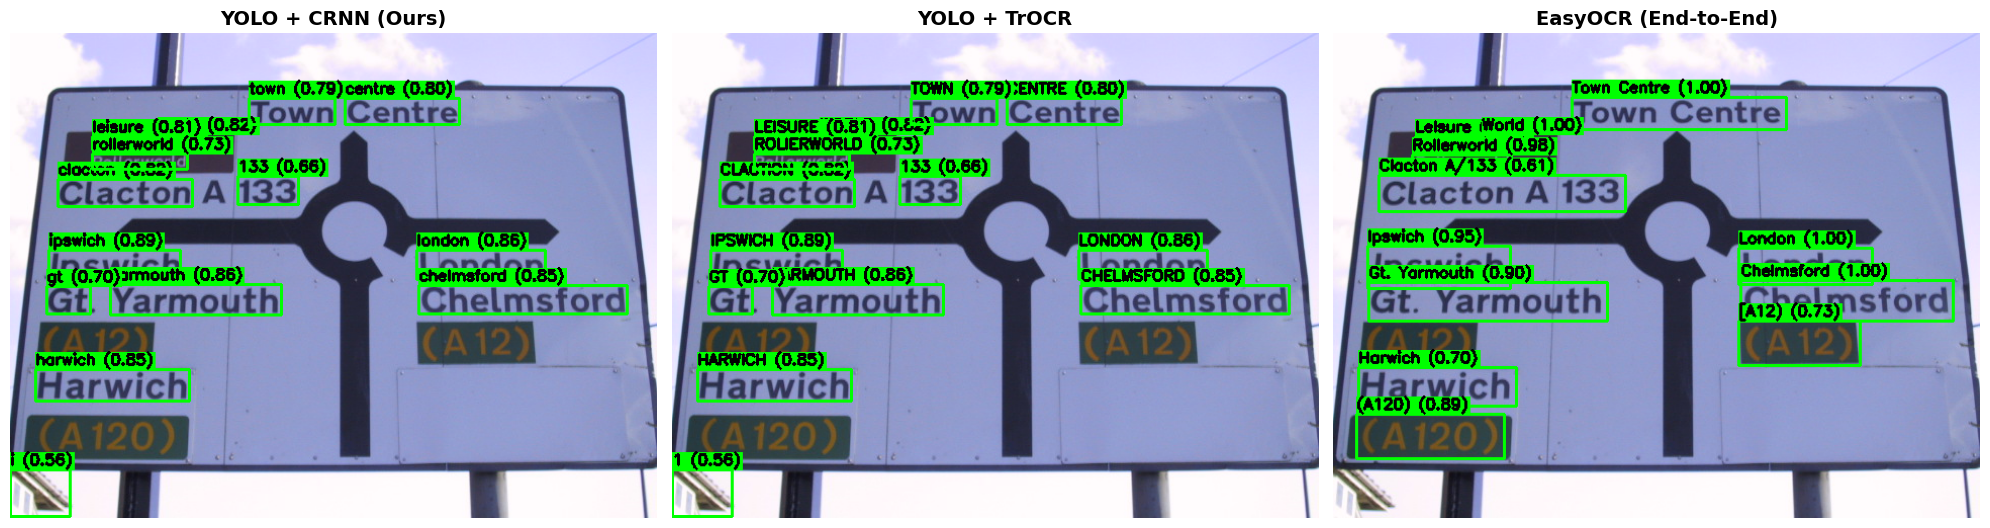

  YOLO+CRNN detected: 14 regions
    1. ipswich (conf: 0.886)
    2. yarmouth (conf: 0.861)
    3. london (conf: 0.860)
    4. harwich (conf: 0.851)
    5. chelmsford (conf: 0.849)
    6. world (conf: 0.819)
    7. clacton (conf: 0.815)
    8. leisure (conf: 0.810)
    9. centre (conf: 0.797)
    10. town (conf: 0.789)
    11. rollerworld (conf: 0.733)
    12. gt (conf: 0.703)
    13. 133 (conf: 0.655)
    14. i (conf: 0.555)

  YOLO+TrOCR detected: 14 regions
    1. IPSWICH (conf: 0.886)
    2. YARMOUTH (conf: 0.861)
    3. LONDON (conf: 0.860)
    4. HARWICH (conf: 0.851)
    5. CHELMSFORD (conf: 0.849)
    6. WORLD (conf: 0.819)
    7. CLACTION (conf: 0.815)
    8. LEISURE (conf: 0.810)
    9. CENTRE (conf: 0.797)
    10. TOWN (conf: 0.789)
    11. ROLIERWORLD (conf: 0.733)
    12. GT (conf: 0.703)
    13. 133 (conf: 0.655)
    14. 1 (conf: 0.555)

  EasyOCR detected: 12 regions
    1. Town Centre (conf: 1.000)
    2. Lelsure (conf: 0.604)
    3. World (conf: 0.996)
    4. Rollerwor

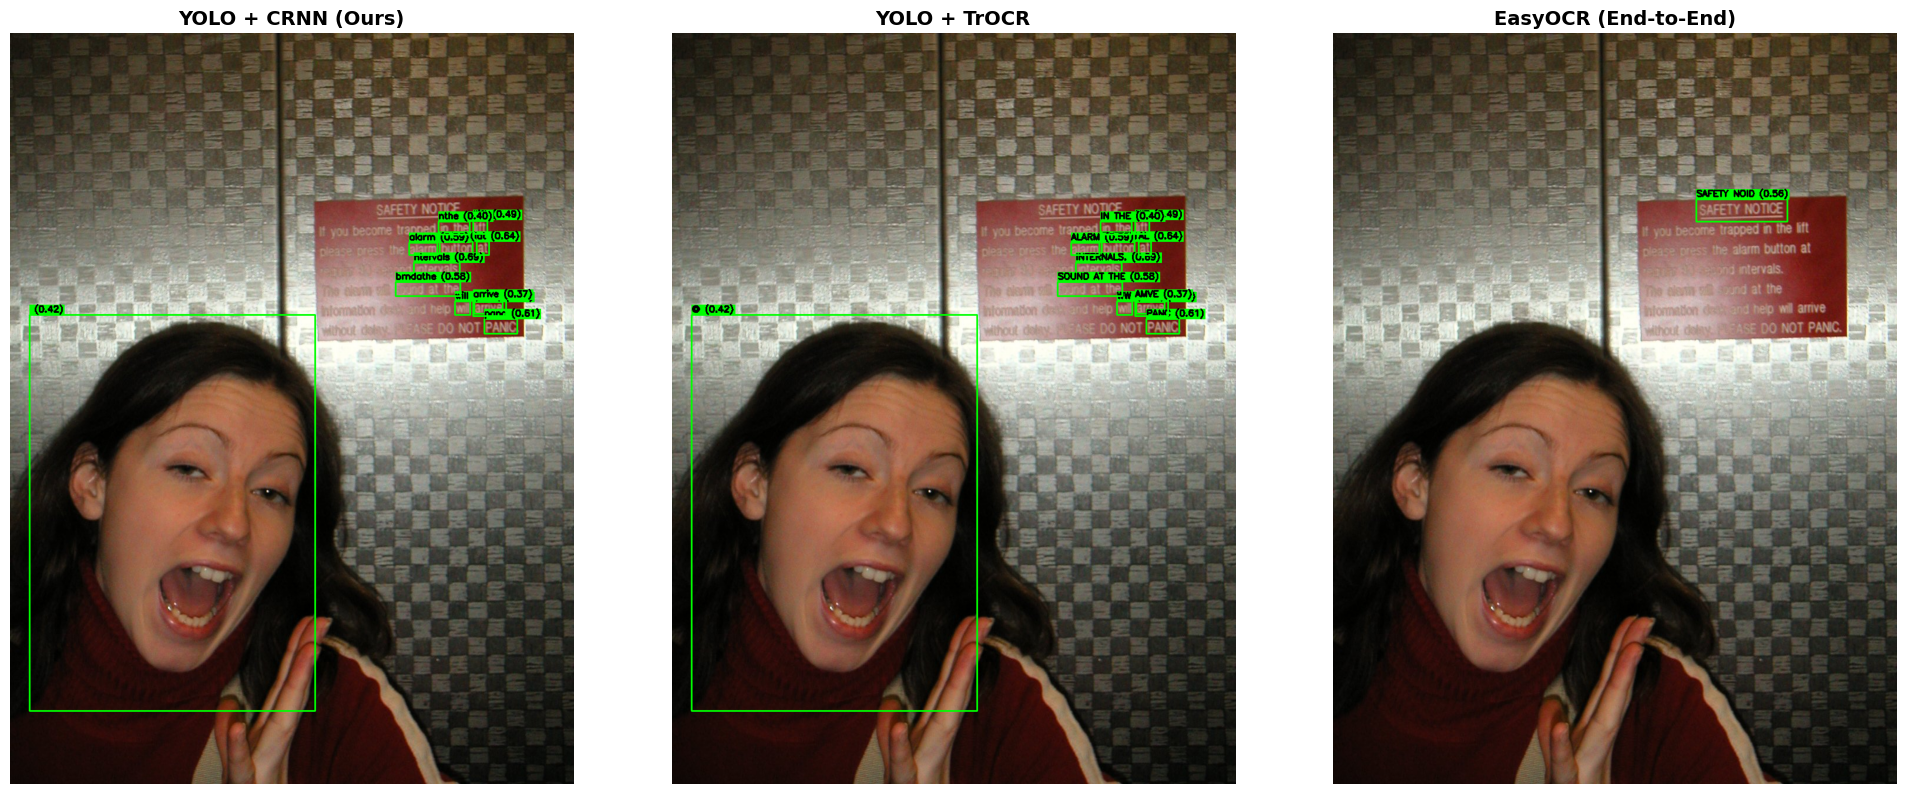

  YOLO+CRNN detected: 12 regions
    1. arrive (conf: 0.742)
    2. buton (conf: 0.707)
    3. ntervals (conf: 0.688)
    4. at (conf: 0.639)
    5. panc (conf: 0.610)
    6. will (conf: 0.602)
    7. alarm (conf: 0.589)
    8. brndathe (conf: 0.577)
    9. llift (conf: 0.494)
    10.  (conf: 0.420)
    11. nthe (conf: 0.401)
    12. arrive (conf: 0.370)

  YOLO+TrOCR detected: 12 regions
    1. AMIVE (conf: 0.742)
    2. BUTTON (conf: 0.707)
    3. INTERNALS. (conf: 0.688)
    4. AL (conf: 0.639)
    5. PANC (conf: 0.610)
    6. WW (conf: 0.602)
    7. ALARM (conf: 0.589)
    8. SOUND AT THE (conf: 0.577)
    9. NIT (conf: 0.494)
    10. @ (conf: 0.420)
    11. IN THE (conf: 0.401)
    12. AMVE (conf: 0.370)

  EasyOCR detected: 1 regions
    1. SAFETY NOID (conf: 0.556)




In [ ]:
# Visualize predictions from 3 models on 2 sample images
print("\n" + "="*100)
print("SAMPLE PREDICTIONS VISUALIZATION (2 Sample Images)")
print("="*100)

# Select 2 random sample images
sample_indices = random.sample(range(len(test_data)), min(2, len(test_data)))

for sample_idx in sample_indices:
    sample_img_path = test_data[sample_idx]['image_path']

    print(f"\n{'─'*100}")
    print(f"SAMPLE IMAGE {sample_idx + 1}: {sample_img_path}")
    print(f"{'─'*100}")

    # Get ground truth labels for this image
    gt_labels = [item['label'] for item in test_data if item['image_path'] == sample_img_path]
    print(f"Ground Truth Labels: {gt_labels}")
    print(f"Total regions in this image: {len(gt_labels)}\n")

    # Get predictions with confidence threshold 0.3
    preds_crnn = inference_yolo_crnn(sample_img_path, conf_threshold=0.3)
    preds_trocr = inference_yolo_trocr(sample_img_path, conf_threshold=0.3)
    preds_easyocr = inference_easyocr(sample_img_path, conf_threshold=0.3)

    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    for idx, (preds, title) in enumerate([
        (preds_crnn, 'YOLO + CRNN (Ours)'),
        (preds_trocr, 'YOLO + TrOCR'),
        (preds_easyocr, 'EasyOCR (End-to-End)')
    ]):
        img = cv2.imread(sample_img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        for pred in preds:
            x, y, w, h = pred['bbox']
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Add text
            text = pred['text']
            conf = pred['confidence']
            label = f"{text} ({conf:.2f})"

            # Background for text
            (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.rectangle(img, (x, y-text_h-5), (x+text_w, y), (0, 255, 0), -1)
            cv2.putText(img, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        axes[idx].imshow(img)
        axes[idx].set_title(title, fontsize=14, fontweight='bold')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detection results
    print(f"  YOLO+CRNN detected: {len(preds_crnn)} regions")
    for i, pred in enumerate(preds_crnn):
        print(f"    {i+1}. {pred['text']} (conf: {pred['confidence']:.3f})")

    print(f"\n  YOLO+TrOCR detected: {len(preds_trocr)} regions")
    for i, pred in enumerate(preds_trocr):
        print(f"    {i+1}. {pred['text']} (conf: {pred['confidence']:.3f})")

    print(f"\n  EasyOCR detected: {len(preds_easyocr)} regions")
    for i, pred in enumerate(preds_easyocr):
        print(f"    {i+1}. {pred['text']} (conf: {pred['confidence']:.3f})")

    print("\n")